#**Helper & unused functions**

In [ ]:
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split

from keras.layers import *
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.metrics import *
from keras.optimizers import Adam, RMSprop
from scipy.stats import norm
from keras.preprocessing import image

from keras import backend as K

In [ ]:
import os
import random
import shutil

# Define the source folder containing files to split
source_folder = '/content/drive/MyDrive/VAE/cyberkongz'

# Define the destination folders to store the split files
folder1 = '/content/drive/MyDrive/VAE/train'
folder2 = '/content/drive/MyDrive/VAE/validation'

# Define the ratio of files to split between the two destination folders
split_ratio = 0.8

# Get a list of all files in the source folder
files = os.listdir(source_folder)

# Shuffle the file list to ensure randomness in splitting
random.shuffle(files)

# Calculate the split index based on the split ratio
split_index = int(len(files) * split_ratio)

# Copy the files up to the split index to folder1
for file in files[:split_index]:
    source_file = os.path.join(source_folder, file)
    dest_file = os.path.join(folder1, file)
    shutil.copyfile(source_file, dest_file)

# Copy the files after the split index to folder2
for file in files[split_index:]:
    source_file = os.path.join(source_folder, file)
    dest_file = os.path.join(folder2, file)
    shutil.copyfile(source_file, dest_file)


In [ ]:
import tensorflow as tf
data_dir = '/content/drive/MyDrive/VAE/cyberkongz'
img_height = 680
img_width = 680
batch_size = 16

train_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/drive/MyDrive/VAE/train',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  labels=None)

val_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/drive/MyDrive/VAE/validation',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  labels=None)

Found 1260 files belonging to 1 classes.
Found 315 files belonging to 1 classes.


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
import os 

!mkdir /content/cyberkongz_resized/
dir_path = '/content/drive/MyDrive/VAE/cyberkongz'
dir2_path = '/content/cyberkongz_resized'
for path in os.listdir(dir_path):
  complete_path = os.path.join(dir_path, path)
  img = cv2.imread(complete_path, cv2.IMREAD_UNCHANGED)
  resized = cv2.resize(img, (512,512), interpolation = Image.ANTIALIAS )  #cv2.INTER_AREA
  #cv2_imshow(resized)
  new_complete_path = os.path.join(dir2_path, path)
  cv2.imwrite(new_complete_path,resized)

mkdir: cannot create directory ‘/content/cyberkongz_resized/’: File exists


In [ ]:
!cp -r /content/cyberkongz_resized /content/drive/MyDrive/VAE

#**test**

In [ ]:
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

def build_vae(input_shape, latent_dim, filters):
    width, height, channels = input_shape

    # Define encoder layers
    encoder_input = Input(shape=input_shape)
    x = encoder_input
    for i, f in enumerate(filters):
        x = Conv2D(filters=f, kernel_size=3, strides=2, activation="relu", padding="same", name=f"encoder_conv{i}")(x)
    x = Flatten()(x)
    z_mean = Dense(units=latent_dim, name="z_mean")(x)
    z_log_var = Dense(units=latent_dim, name="z_log_var")(x)

    # Define sampling layer
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.0, stddev=1.0)
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    z = Lambda(sampling, name="z")([z_mean, z_log_var])

    # Define decoder layers
    decoder_input = Input(shape=(latent_dim,))
    x = decoder_input
    x = Dense(units=(width // 16) * (height // 16) * filters[-1], name="decoder_dense")(x)
    x = Reshape(target_shape=((width // 16), (height // 16), filters[-1]), name="decoder_reshape")(x)
    for i, f in reversed(list(enumerate(filters[:-1]))):
        x = Conv2DTranspose(filters=f, kernel_size=3, strides=2, activation="relu", padding="same", name=f"decoder_conv{i}")(x)
    x = Conv2DTranspose(filters=channels, kernel_size=3, strides=2, activation="sigmoid", padding="same", name="decoder_output")(x)

    # Define models
    encoder = Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
    decoder = Model(decoder_input, x, name="decoder")
    vae_output = decoder(z)
    vae = Model(encoder_input, vae_output, name="vae")

    # Define loss function
    def vae_loss(x, x_recon):
        reconstruction_loss = K.sum(K.square(x - x_recon), axis=[1, 2, 3])
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(reconstruction_loss + kl_loss)

    vae.compile(optimizer='Adam', loss=vae_loss)

    return vae


In [ ]:
import tensorflow as tf
# Load the image dataset
data_dir = "/content/drive/MyDrive/VAE/train"
img_height = 512
img_width = 512
batch_size = 1

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    labels=None)

Found 5000 files belonging to 1 classes.
Using 4000 files for training.


In [ ]:
import numpy as np

# Load and preprocess data
train_data = ... # load and preprocess your dataset here
test_data = ... # load and preprocess your dataset here

# Define model
input_shape = (512, 512, 3)
latent_dim = 256
filters = [32, 64, 128, 256]
vae = build_vae(input_shape, latent_dim, filters)

# Train model
batch_size = 32
epochs = 10

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    for step, x_batch in enumerate(train_ds.batch(batch_size)):
        loss = vae.train_on_batch(x_batch, x_batch)
        if step % 100 == 0:
            print(f"Step {step}: loss = {loss}")
    
    # Evaluate on test data
    test_loss = vae.evaluate(test_data, test_data, batch_size=batch_size, verbose=0)
    print(f"Test loss: {test_loss:.4f}")


Epoch 1/10


ValueError: ignored

In [ ]:
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

def build_vae(input_shape):
    width, height, channels = input_shape

    # Define encoder layers
    encoder_input = Input(shape=input_shape)
    x = Conv2D(filters=32 * (width // 64), kernel_size=3, strides=2, activation="relu", padding="same")(encoder_input)
    x = Conv2D(filters=64 * (width // 64), kernel_size=3, strides=2, activation="relu", padding="same")(x)
    x = Conv2D(filters=128 * (width // 64), kernel_size=3, strides=2, activation="relu", padding="same")(x)
    x = Conv2D(filters=256 * (width // 64), kernel_size=3, strides=2, activation="relu", padding="same")(x)
    x = Flatten()(x)
    z_mean = Dense(units=latent_dim)(x)
    z_log_var = Dense(units=latent_dim)(x)

    # Define sampling layer
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.0, stddev=1.0)
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    z = Lambda(sampling)([z_mean, z_log_var])

    # Define decoder layers
    decoder_input = Input(shape=(latent_dim,))
    x = Dense(units=(width // 16) * (height // 16) * 256)(decoder_input)
    x = Reshape(target_shape=((width // 16), (height // 16), 256))(x)
    x = Conv2DTranspose(filters=128 * (width // 64), kernel_size=3, strides=2, activation="relu", padding="same")(x)
    x = Conv2DTranspose(filters=64 * (width // 64), kernel_size=3, strides=2, activation="relu", padding="same")(x)
    x = Conv2DTranspose(filters=32 * (width // 64), kernel_size=3, strides=2, activation="relu", padding="same")(x)
    x = Conv2DTranspose(filters=channels, kernel_size=3, strides=2, activation="sigmoid", padding="same")(x)

    # Define models
    encoder = Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
    decoder = Model(decoder_input, x, name="decoder")
    vae_output = decoder(z)
    vae = Model(encoder_input, vae_output, name="vae")

    # Define loss function
    def vae_loss(x, x_recon):
        reconstruction_loss = K.sum(K.square(x - x_recon), axis=[1, 2, 3])
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(reconstruction_loss + kl_loss)

    vae.compile(optimizer=optimizer, loss=vae_loss)

    return vae


#**Load Data & Model Construction**

In [ ]:
img = cv2.imread('/content/drive/MyDrive/VAE/cyberkongz/1.png')
dimensions = img.shape
dimensions

(680, 680, 3)

In [ ]:
import tensorflow as tf
import numpy as np
import os

# Load the image dataset
data_dir = "/content/drive/MyDrive/VAE/train"
img_height = 512
img_width = 512
batch_size = 4

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    labels=None)

def normalize(x):
    x = tf.cast(x, tf.float32)
    x = x / 255.0
    x = (x - 0.5) * 2.0
    return x

train_ds = train_ds.map(normalize)

#train_ds = train_ds.map(lambda x: x/255.0)

#train_ds = train_ds.map(lambda x: (tf.image.resize(x, (img_height, img_width)) - 0.5) * 2)

train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Preprocess the images
#train_ds = train_ds.map(lambda x: tf.image.resize(x, (img_height, img_width))/255.0,)

# Prepare the data
#train_ds = train_ds.map(lambda x: (x, x)) # VAE requires input and output to be same


Found 5000 files belonging to 1 classes.
Using 4000 files for training.


In [ ]:
min_val = 1.0
max_val = 0.0
for x in train_ds:
    min_val = tf.reduce_min(x).numpy()
    max_val = tf.reduce_max(x).numpy()
    
print(f"Minimum pixel value: {min_val:.4f}")
print(f"Maximum pixel value: {max_val:.4f}")


Minimum pixel value: -1.0000
Maximum pixel value: 1.0000


In [ ]:
import tensorflow.keras.backend as K
import tensorflow as tf
latent_dim = 100

encoder_inputs = tf.keras.layers.Input(shape=(img_height, img_width, 3))
x = tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same")(encoder_inputs)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)

z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)

encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

latent_inputs = tf.keras.layers.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(256, activation="relu")(latent_inputs)
#x = tf.keras.layers.Dense(512 * 512 * 32, activation="relu")(x)
x = tf.keras.layers.Dense(256 * 256 * 32, activation="relu")(x)
x = tf.keras.layers.Reshape((256, 256, 32))(x)

x = tf.keras.layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = tf.keras.layers.Dropout(0.2)(x)
decoder_outputs = tf.keras.layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")


class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100,))
        return self.decode(eps, apply_sigmoid=True)

    def sampling(self,z_mean,z_log_var):
        #z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.0, stddev=1.0)
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    def encode(self, x):
        mean, logvar = self.encoder(x)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

# Define the VAE model
vae = VAE(encoder, decoder)

# Define the loss function
def vae_loss(encoder, decoder, x, z_mean, z_log_var):
    reconstruction_loss = tf.reduce_mean(tf.square(x - decoder(z_mean)))

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)
epochs = 5
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    kl_losses = []
    for step, x in enumerate(train_ds):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = vae.encode(x)
            z = vae.reparameterize(z_mean, z_log_var)
            x_recon = vae.decode(z)

            #print(x.shape)
            #print(x_recon.shape)

            # Compute reconstruction loss
            reconstruction_loss = tf.reduce_mean(tf.square(x - x_recon))
            #reconstruction_loss *= 255.0**2  # Scale by factor to account for normalization

            # Compute KL divergence loss with weight decay
            weight_decay = 0.1
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
                              
            # Compute total loss
            beta = 0.1 * epoch / epochs  # Increase beta gradually during training
            total_loss = reconstruction_loss + weight_decay * kl_loss


        # Compute gradients and update weights
        grads = tape.gradient(total_loss, vae.trainable_weights)
        optimizer.apply_gradients(zip(grads, vae.trainable_weights))

        # Log progress
        if step % 100 == 0:
            print(f"Step {step}: Reconstruction loss = {reconstruction_loss.numpy():.4f}, KL loss = {kl_loss.numpy():.4f}, Total loss = {total_loss.numpy():.4f}")

        kl_losses.append(kl_loss)

    # Calculate and print the average KL loss for the epoch
    avg_kl_loss = tf.reduce_mean(kl_losses)
    print(f"Epoch {epoch+1} average KL loss: {avg_kl_loss.numpy():.4f}")

    # Save model weights every epoch
    vae.save_weights("vae_weights.h5")


Epoch 1/5


Step 0: Reconstruction loss = 0.8903, KL loss = 0.0000, Total loss = 0.8903
Step 100: Reconstruction loss = 0.9893, KL loss = 0.0000, Total loss = 0.9893
Step 200: Reconstruction loss = 0.7823, KL loss = 0.0000, Total loss = 0.7823
Step 300: Reconstruction loss = 0.8213, KL loss = 0.0000, Total loss = 0.8213
Step 400: Reconstruction loss = 0.8572, KL loss = 0.0000, Total loss = 0.8572
Step 500: Reconstruction loss = 0.9186, KL loss = 0.0000, Total loss = 0.9186
Step 600: Reconstruction loss = 0.8574, KL loss = 0.0000, Total loss = 0.8574
Step 700: Reconstruction loss = 0.9605, KL loss = 0.0000, Total loss = 0.9605
Step 800: Reconstruction loss = 0.7642, KL loss = 0.0000, Total loss = 0.7642
Step 900: Reconstruction loss = 0.8421, KL loss = 0.0000, Total loss = 0.8421
Epoch 1 average KL loss: 0.0000
Epoch 2/5
Step 0: Reconstruction loss = 0.8886, KL loss = 0.0000, Total loss = 0.8886
Step 100: Reconstruction loss = 0.9873, KL loss = 0.0000, Total loss = 0.9873
Step 200: Reconstruction l

In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image

# Load your trained VAE model here
vae = ...

# Load your input image here using a suitable image loading library
image = Image.open("/content/drive/MyDrive/VAE/train/10.png")#.resize((64, 64))

# Convert the image to a tensor
image_tensor = tf.convert_to_tensor(np.array(image))
#
image_tensor = tf.cast(image_tensor, tf.float32)

#normalize photo 
image_tensor = tf.map_fn(normalize,image_tensor)

# Add a batch dimension to the tensor
image_tensor = tf.expand_dims(image_tensor, axis=0)

# Call vae.encode() on the input tensor to obtain mean and log variance of latent space
z_mean, z_log_var = vae.encode(image_tensor.numpy())

# Use mean and log variance to generate latent space vector using vae.reparameterize()
z = vae.reparameterize(z_mean, z_log_var)

# Call vae.decode() on latent space vector to generate reconstructed image
reconstructed_image = vae.decode(z)

# Convert reconstructed image tensor to a numpy array
reconstructed_image_array = reconstructed_image.numpy()

# Visualize input image and reconstructed image side-by-side
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(image)
axes[0].set_title("Input Image")
axes[1].imshow(reconstructed_image_array[0])
axes[1].set_title("Reconstructed Image")
plt.show()


AttributeError: ignored

In [ ]:
filepath = '/content/drive/MyDrive/VAE/train/1.png'
image = cv2.imread(filepath)
image = asarray(image)
image = np.expand_dims(image, axis=0)
z_mean,z_log_var = vae.encode(image)
#print(z_mean,z_log_var)

In [ ]:
filepath = '/content/drive/MyDrive/VAE/train/5.png'
image = cv2.imread(filepath)
image = asarray(image)
image = np.expand_dims(image, axis=0)
z_mean1,z_log_var1 = vae.encode(image)

In [ ]:
import tensorflow as tf
tf.math.equal(z_mean,z_mean1)

<tf.Tensor: shape=(1, 100), dtype=bool, numpy=
array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False]])>

In [ ]:
import os
import cv2
from numpy import asarray

directory = '/content/drive/MyDrive/VAE/train'
i = 0
for filename in os.listdir(directory):
    if filename.endswith('.png') and i < 5:  # only process .txt files
        filepath = os.path.join(directory, filename)
        image = cv2.imread(filepath)
        image = asarray(image)
        image = np.expand_dims(image, axis=0)
        z_mean,z_log_var = vae.encode(image)
        print(z_mean,z_log_var)
        i = i+1
    else:
      continue


tf.Tensor(
[[ -2.0033805   17.080898    -1.2972615    0.6946153   42.850464
  -17.846684   -22.432886   -39.693752   -16.073637   -38.588314
   -4.6271667    6.946963     0.41680136  23.577217   -12.020315
  -13.338169    14.808459     5.3561153   24.368383    43.657448
   31.696087    38.267162   -20.322063     2.8362198   -8.464914
   29.996197    -6.46824     -5.455508   -66.50456     41.02135
   21.2962     -39.56283    -16.396925    74.125496     3.564946
   -4.2043786  -14.590085   -51.189846     7.3757915   33.475266
   19.19889    -17.283398    11.663569    40.85026    -44.055843
   18.317533    -5.747716     8.47699     21.63666      8.281494
    5.411768   -23.097197   -12.7886505   -6.181515   -23.170536
   -8.171186    14.837403    16.134438   -10.210181    24.325218
   -0.55579317   6.971418   -23.775484   -46.017097   -38.902187
   -8.248863    35.389267    -3.739119    -8.998779    15.531243
   22.274834     8.296277   -18.661232   -18.370853    26.866049
  -52.223984   

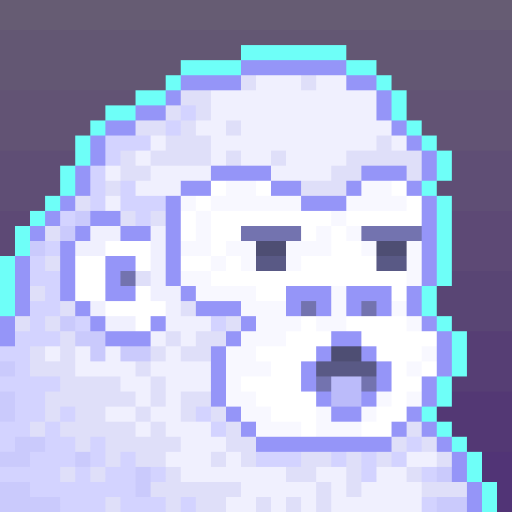

AttributeError: ignored

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
from matplotlib import image
from PIL import Image
from numpy import asarray

image = cv2.imread('/content/drive/MyDrive/VAE/train/1.png')
#image = cv2.resize(image, (256,256), interpolation = Image.ANTIALIAS )  #cv2.INTER_AREA
cv2_imshow(image)
image = asarray(image)

image = np.expand_dims(image, axis=0)
#print(img)
z_mean,z_log_var = vae.encode(image)
#print(z_mean,z_log_var)
z = vae.reparameterize(z_mean, z_log_var)
#z = vae.sampling(z_mean, z_log_var)

x_recon = vae.decode(z)
x_recon = x_recon.numpy()
#print(x_recon.shape)
x_recon = np.squeeze(x_recon)
def map1(x):
  return x*255.0
def map2(x):
  return tf.image.resize(x, (img_height, img_width))
def denormalize(x):
    x = 0.5 * (x + 1.0)
    x = x * 255.0
    x = tf.cast(x, tf.float32)
    return x

x_recon = np.vectorize(denormalize)(x_recon)
#x_recon = np.vectorize(map2)(x_recon)
#x_recon = x_recon.map(lambda x: x*255.0)
#x_recon = x_recon.map(lambda x: tf.image.resize(x, (img_height, img_width)))
cv2_imshow(x_recon)
#for step, x in enumerate(train_ds):
 #  z_mean, z_log_var = vae.encode(x)
 #  print(len(z_mean),len(z_log_var))